In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sat Jan 31 20:50:27 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.00000000

In [2]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.01,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.


# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 42
#


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [4]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.01
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [99]:
from ad_afqmc import linalg_utils
from jax import lax

@jit
def uwalker_norm(
    walker_up: jax.Array,
    walker_dn: jax.Array,
) -> float:
    norm = jnp.linalg.det(walker_up.T.conj() @ walker_up
        ) * jnp.linalg.det(walker_dn.T.conj() @ walker_dn)
    return jnp.real(norm)

@jit
def stochastic_reconfiguration_uhf(walkers, weights, zeta):
    nwalkers = walkers[0].shape[0]
    cumulative_weights = jnp.cumsum(jnp.abs(weights))
    total_weight = cumulative_weights[-1]
    average_weight = total_weight / nwalkers
    weights = jnp.ones(nwalkers) * average_weight
    z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
    indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
    walkers[0] = walkers[0][indices]
    walkers[1] = walkers[1][indices]
    return walkers, weights

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= weights
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data

@partial(jit, static_argnums=(3))
def fp_step(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_sr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, fields

@partial(jit, static_argnums=(2, 3, 5))
def fp_block(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    # prop_data["overlaps"] = prop_data["overlaps"] / jnp.sum(prop_data["overlaps"])
    # prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])
    # block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])

    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = jnp.abs((trial.calc_overlap(prop_data["walkers"], wave_data)))
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_srabs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = jnp.abs((trial.calc_overlap(prop_data["walkers"], wave_data)))
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])

    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
    # # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, (block_energy, block_weight)

In [57]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    # prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["weights"] = jnp.ones(prop.n_walkers)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-108.52346313844816


In [64]:
nstep = 50
fp_e = np.zeros(nstep+1,dtype=np.complex128)
fp_w = np.zeros(nstep+1,dtype=np.complex128)
fp_e[0] = prop_data["e_estimate"]
fp_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_e[n+1] = blk_e
    fp_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.60397546151437-0.00901459296951759j) (-10.59760489522803+0.04240108182525351j)
2 (-108.54329700179115-0.0010596319286312267j) (-9.915871164299075+0.14189489559601562j)
3 (-108.73053277936333-0.018635077958189063j) (-7.170007700269565+0.14285691872961104j)
4 (-108.75453723998099+0.05932128101706214j) (-1.7120869388092388+0.052612050689034656j)
5 (-108.59475993429663-0.0026559820251359028j) (-2.5635132274588672+0.24046061937568325j)
6 (-108.61509583646269+0.1586203245733484j) (-3.342222263623444-1.392247096668778j)
7 (-108.42729385047926+0.19487515945921302j) (1.2560420989822072-1.2214808645585262j)
8 (-108.50509500152505+0.023335372723822065j) (-3.589898811677812+1.5620595701023996j)
9 (-108.70759797319737+0.0565677609373666j) (-4.742438734894449-0.6408729364716964j)
10 (-108.49309290571505-0.3661082941884645j) (-0.29972832930916704-2.039523752232406j)
11 (-108.64661045654971+0.03488877661585577j) (8.429003004996996+1.3598156867884263j)
12 (-108.58632922802886+0.0390237946788656

In [67]:
prop_data["weights"]

Array([3.48046709e-01, 1.27550543e-03, 1.40836018e-05, 8.32616100e-04,
       3.15523571e-03, 7.83912170e-01, 9.58626688e-02, 1.57899315e-02,
       1.17478319e-01, 4.12939230e-01, 6.58875184e-04, 4.02157827e-05,
       2.28145516e-04, 3.34245741e-04, 6.02329570e-02, 4.79892557e-03,
       9.86565373e+00, 1.14976346e-03, 1.27455236e+00, 6.41082938e-01,
       5.29383155e-03, 2.92010598e-02, 4.65820912e-01, 4.33892160e-04,
       1.13706406e-02, 1.67347223e-02, 8.48208227e-01, 1.00752594e-02,
       3.27913241e-03, 4.45187190e-05, 4.94019606e-03, 4.94605009e-04,
       3.41091596e-03, 5.70280407e-06, 1.79614601e-03, 4.66026346e-02,
       2.32944781e-04, 2.58993440e-01, 1.61487208e-01, 2.14748792e-04,
       1.05660156e-04, 1.19155290e-02, 5.85695601e-01, 1.35866538e-02,
       1.09458777e-04, 5.09674084e-02, 8.99409209e-04, 1.65377332e+01,
       1.52315510e+00, 1.57791527e+01], dtype=float64)

In [59]:
jnp.sum(prop_data["overlaps"])

Array(2.29759277-1.15642989j, dtype=complex128)

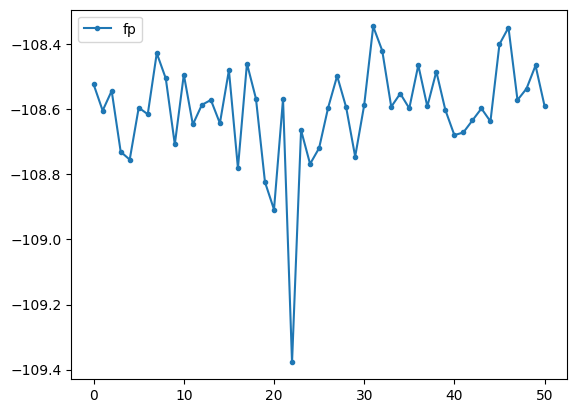

In [68]:
from matplotlib import pyplot as plt

plt.plot(fp_e.real,'.-',label='fp',color='C0')

plt.legend()
plt.show()

In [78]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
-108.52346313844816


In [79]:
nstep = 50
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.62087798401605-0.012842059982120025j) (-11.436269043783795+0.12667458428811657j)
2 (-108.44421742271591+0.027569064841115418j) (-1.6363243349956478-0.28772936883382016j)
3 (-108.77438728654462+0.026348552119374563j) (-4.537838583802741+0.1060033792504555j)
4 (-108.41641151644079-0.007977862785755354j) (2.97250751016119-0.4822300938461487j)
5 (-108.62748942676612-0.009561568095036091j) (-10.425029286922516-0.9942298305226949j)
6 (-108.66150180499345+0.08056417333751431j) (-6.252260640565699-1.3417471199730089j)
7 (-108.84463421339672-0.1368409966066647j) (-2.6340329487726795+0.502523137555657j)
8 (-108.5636170778895-0.00956751421136809j) (-9.675148729834097-0.824892287632528j)
9 (-108.85445256155018-0.4079807590768868j) (-0.95303353382939+0.5498641899143224j)
10 (-108.67568012044048+0.006012225203665514j) (-7.674776949442367-0.22808379267963919j)
11 (-108.71414081747936+0.01765964487119801j) (-5.585549736824403+0.1236614161985643j)
12 (-108.69120365066469-0.2030085517758966j) (-

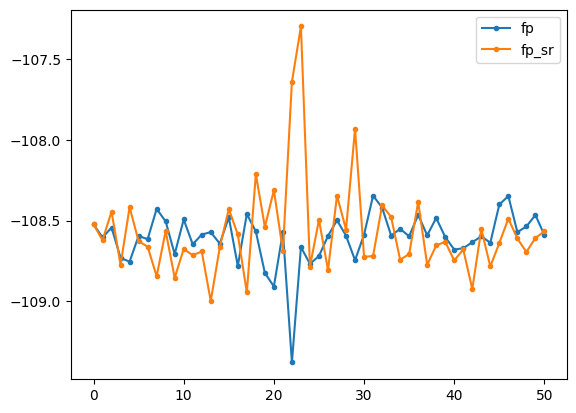

In [80]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

In [81]:
prop_data["overlaps"]

Array([ 0.14221462+0.37366643j, -0.53348354-0.40755785j,
       -0.26424174-0.28086949j, -0.0179937 +0.34565917j,
        0.46960541+0.13140756j, -0.27820751-0.04581639j,
        0.06328224+0.05355221j,  0.00214645-0.23133541j,
       -0.60014974-0.05286949j, -0.30677327+0.05501366j,
        0.21081569-0.19909372j, -0.4841378 +0.14984881j,
        0.38520421-0.06383853j,  0.24068987-0.07111861j,
        0.02573573-0.01353379j,  0.23921294-0.29099093j,
        0.58079763-0.06274228j,  0.13946575+0.06723009j,
       -0.15582053+0.0875778j ,  0.18163257-0.11658006j,
        0.6573628 +0.22212302j,  0.52146764-0.25162787j,
        0.23545169-0.03380886j,  0.2746784 +0.15294845j,
        0.33106759-0.06619628j, -0.43396709-0.12414197j,
        0.02763283+0.01764628j,  0.47145891-0.16155421j,
       -0.42520365-0.10677859j,  0.59963645+0.25533839j,
       -0.47653948-0.18096275j,  0.62519788+0.22718715j,
        0.08860893-0.52228006j, -0.64062113-0.07583878j,
        0.59295885+0.06251606j,

In [82]:
prop_data["weights"]

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float64)

In [100]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
-108.52346313844816


In [101]:
nstep = 50
fp_abs_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_e[0] = prop_data["e_estimate"]
fp_abs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs_e[n+1] = blk_e
    fp_abs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61388523467751+0.0011670219494639318j) 34.66820919468785
2 (-108.63579724114248+0.0007979653691062811j) 29.75067039851767
3 (-108.65062446928835+0.010114845668214939j) 25.393892039273897
4 (-108.67687350392582+0.008884878746910945j) 22.89651583408586
5 (-108.62316645734869-0.007673951638534211j) 24.435109489511248
6 (-108.62078655697495-0.006346776457105375j) 24.446166217490752
7 (-108.62337136909386+0.005255258983486451j) 22.603839387324662
8 (-108.60502798274854-0.015630521274124263j) 23.56573943462588
9 (-108.63799265097282+0.00015944121662981575j) 22.833931423234233
10 (-108.62377222504372-0.010514573553756762j) 23.95221321224463
11 (-108.64759982855233-0.0073508176088138j) 21.044719838715316
12 (-108.64746460234467+0.013501703182681398j) 20.328184654983563
13 (-108.66717944811829+0.028877340088853655j) 19.943130581879554
14 (-108.65262862199279+0.04864018248334154j) 20.384414187741875
15 (-108.61290490462906+0.026917229134635047j) 21.17229232651882
16 (-108.58375214593175+

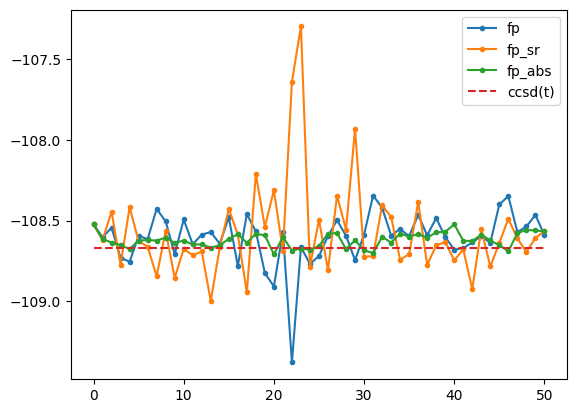

In [86]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_abs',color='C2')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C3')
plt.legend()
plt.show()

In [ ]:
prop_data["weights"]

Array([3.48046709e-01, 1.27550543e-03, 1.40836018e-05, 8.32616100e-04,
       3.15523571e-03, 7.83912170e-01, 9.58626688e-02, 1.57899315e-02,
       1.17478319e-01, 4.12939230e-01, 6.58875184e-04, 4.02157827e-05,
       2.28145516e-04, 3.34245741e-04, 6.02329570e-02, 4.79892557e-03,
       9.86565373e+00, 1.14976346e-03, 1.27455236e+00, 6.41082938e-01,
       5.29383155e-03, 2.92010598e-02, 4.65820912e-01, 4.33892160e-04,
       1.13706406e-02, 1.67347223e-02, 8.48208227e-01, 1.00752594e-02,
       3.27913241e-03, 4.45187190e-05, 4.94019606e-03, 4.94605009e-04,
       3.41091596e-03, 5.70280407e-06, 1.79614601e-03, 4.66026346e-02,
       2.32944781e-04, 2.58993440e-01, 1.61487208e-01, 2.14748792e-04,
       1.05660156e-04, 1.19155290e-02, 5.85695601e-01, 1.35866538e-02,
       1.09458777e-04, 5.09674084e-02, 8.99409209e-04, 1.65377332e+01,
       1.52315510e+00, 1.57791527e+01], dtype=float64)

In [103]:
prop_data["overlaps"]

Array([0.40159005, 0.05918297, 0.40964004, 0.48750285, 0.24073815,
       0.54106776, 0.1118493 , 0.07632456, 0.40347455, 0.05247258,
       0.25078074, 0.13269304, 0.37627102, 0.00099142, 0.44255398,
       0.40517089, 0.41986732, 0.29190983, 0.00742736, 0.25787631,
       0.33626519, 0.43297151, 0.18076409, 0.20592151, 0.574394  ,
       0.0542169 , 0.32967601, 0.07319307, 0.21802776, 0.05277751,
       0.32366222, 0.12075434, 0.04962891, 0.24287381, 0.20759512,
       0.54873361, 0.11439829, 0.30132579, 0.48814706, 0.08733421,
       0.76284946, 0.00296257, 0.30664828, 0.65604469, 0.04699095,
       0.48662117, 0.07309693, 0.34447719, 0.31950375, 0.6498643 ],      dtype=float64)

In [105]:
walkers_abs = prop_data["walkers"]

In [106]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
-108.52346313844816


In [107]:
nstep = 50
fp_srabs_e = np.zeros(nstep+1,dtype=np.complex128)
fp_srabs_w = np.zeros(nstep+1,dtype=np.complex128)
fp_srabs_e[0] = prop_data["e_estimate"]
fp_srabs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_srabs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_srabs_e[n+1] = blk_e
    fp_srabs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61655739781087+0.0017422606125013244j) 34.47428801396689
2 (-108.63056960202479-0.003931009929149604j) 29.87953078215294
3 (-108.64500485320974+0.010268062186482976j) 28.246335375784646
4 (-108.65186178463486+0.005711836648936526j) 26.751009867592778
5 (-108.6455767159425+0.0039722960771668685j) 25.274694785523415
6 (-108.6369975151213+0.005547497746833732j) 25.986069497477665
7 (-108.67995506502676-0.014334458462260119j) 23.00379706291236
8 (-108.62770345598214-0.0016356142378245746j) 25.604646729350865
9 (-108.64696032224188-0.006292039408213079j) 23.77415586245497
10 (-108.62349870550689+0.014737558263993639j) 24.692664222483536
11 (-108.66829976997212+0.008168461390510562j) 22.205565137524147
12 (-108.6774155153594-0.02222294076920646j) 21.899373480105755
13 (-108.63044484254334+0.004188765735929087j) 23.694653510290788
14 (-108.6558118562295+0.006582632269918227j) 20.752086401913996
15 (-108.62371261772742+0.000661964497886243j) 22.115406853364394
16 (-108.60806666056939-1

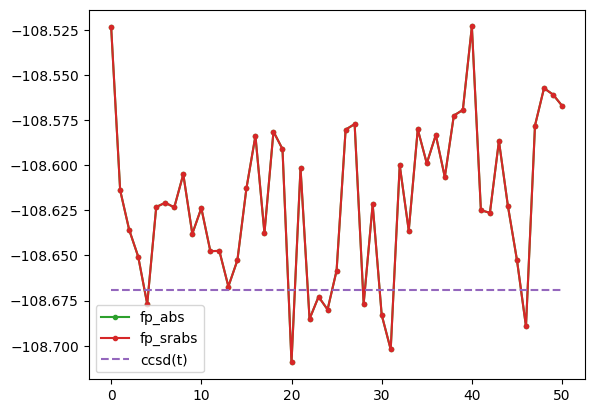

In [108]:
# plt.plot(fp_e.real,'.-',label='fp',color='C0')
# plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_abs',color='C2')
plt.plot(fp_abs_e.real,'.-',label='fp_srabs',color='C3')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [111]:
prop_data["weights"]

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float64)

In [109]:
prop_data["overlaps"]

Array([0.39981445, 0.67134797, 0.38563113, 0.34612719, 0.48764453,
       0.28195489, 0.08290043, 0.23134537, 0.60247397, 0.31166703,
       0.28996821, 0.50679786, 0.39045824, 0.25097703, 0.02907733,
       0.37669424, 0.58417676, 0.15482435, 0.17874537, 0.21582701,
       0.69387642, 0.57900353, 0.23786663, 0.3143906 , 0.33762064,
       0.45137419, 0.03278665, 0.49837062, 0.43840599, 0.65173734,
       0.50974248, 0.66519651, 0.52974334, 0.64509453, 0.5962453 ,
       0.69359569, 0.37170994, 0.31259196, 0.35008465, 0.81056885,
       0.37983302, 0.41464329, 0.16194361, 0.37411093, 0.348969  ,
       0.47485525, 0.45499766, 0.2082565 , 0.50705771, 0.61814089],      dtype=float64)

In [112]:
walkers_srabs = prop_data["walkers"]

In [114]:
print(walkers_abs[0][0])

[[-5.06522165e-01-1.44790150e-01j  2.44320102e-01+8.11706555e-01j
   1.91314974e-03+2.16582483e-02j  1.51212343e-02-2.26485814e-02j
   1.05435626e-02+3.51425825e-03j  1.71437319e-02-1.47339172e-02j
  -1.86362567e-03+1.18461625e-02j]
 [-4.70278639e-01+7.04723781e-01j -5.27687980e-01-1.19996810e-02j
  -2.58643823e-03+2.74427234e-02j  5.68026881e-03-1.16384754e-02j
   4.29851830e-03-3.08947858e-02j  2.04474700e-02-1.53926982e-02j
   1.47371027e-03+3.31793905e-04j]
 [ 1.44883847e-02+1.45056289e-02j  1.23075620e-02+1.43331951e-02j
  -6.94369258e-01-4.40473904e-01j  2.32662432e-01-2.23870654e-01j
   1.51967680e-01-3.43502093e-01j -2.87462423e-04-5.36209400e-02j
   7.78134122e-02+3.50155908e-02j]
 [-4.68017674e-03-2.62125947e-02j -5.90663876e-03-3.95064515e-04j
  -5.07816278e-02-2.25167008e-02j -1.41221170e-01+1.51716111e-01j
   8.39933262e-02-2.45385661e-01j  9.20584478e-02-7.22557941e-01j
  -2.66501865e-01-2.21517996e-01j]
 [-2.19591793e-02-1.96537488e-02j -1.56411174e-02-1.21751471e-02j
  

In [117]:
print(walkers_srabs[0][0])

[[-2.40281308e-01+6.08166160e-01j  4.24613686e-01-6.23794603e-01j
   1.75933014e-02+1.89665987e-02j  2.52252412e-04-2.45506946e-02j
   1.23309617e-02-2.01493268e-02j -8.07946393e-03+5.13657687e-03j
   9.89910280e-03-1.90669607e-03j]
 [-6.69934829e-01-3.46561930e-01j -5.01546158e-01-4.19312474e-01j
   1.41191069e-02+2.17299385e-02j -2.45884090e-02-6.31574829e-03j
   1.80278543e-02+6.51954691e-04j -2.74439188e-03-1.56731723e-02j
   2.02636698e-02+5.86128000e-03j]
 [ 1.17737420e-02+1.76611863e-02j -2.63218934e-02+1.04112417e-02j
  -1.00829465e-01+8.63784763e-01j  2.28136438e-01-5.74190023e-02j
  -2.66976648e-01+8.45323248e-02j -3.09660952e-02+5.75786255e-02j
   1.35438704e-01+1.59276643e-01j]
 [-1.14602615e-02-1.25513971e-02j  2.50660199e-02-8.80023182e-04j
   1.53366946e-01+7.11315342e-02j -4.47327793e-01+2.52505511e-01j
  -5.26153903e-01+1.34834107e-03j -4.19213454e-01-2.49321056e-01j
  -2.00416844e-01+1.40380947e-02j]
 [-1.11223593e-02-1.28589094e-02j  1.36125895e-02-3.72114291e-03j
  

In [115]:
print(walkers_srabs[0][0]-walkers_abs[0][0])

[[ 0.26624086+7.52956310e-01j  0.18029358-1.43550116e+00j
   0.01568015-2.69164967e-03j -0.01486898-1.90211320e-03j
   0.0017874 -2.36635851e-02j -0.0252232 +1.98704941e-02j
   0.01176273-1.37528586e-02j]
 [-0.19965619-1.05128571e+00j  0.02614182-4.07312793e-01j
   0.01670555-5.71278493e-03j -0.03026868+5.32272710e-03j
   0.01372934+3.15467405e-02j -0.02319186-2.80474129e-04j
   0.01878996+5.52948610e-03j]
 [-0.00271464+3.15555741e-03j -0.03862946-3.92195343e-03j
   0.59353979+1.30425867e+00j -0.00452599+1.66451651e-01j
  -0.41894433+4.28034418e-01j -0.03067863+1.11199565e-01j
   0.05762529+1.24261052e-01j]
 [-0.00678008+1.36611976e-02j  0.03097266-4.84958667e-04j
   0.20414857+9.36482349e-02j -0.30610662+1.00789400e-01j
  -0.61014723+2.46734002e-01j -0.5112719 +4.73236885e-01j
   0.06608502+2.35556091e-01j]
 [ 0.01083682+6.79483941e-03j  0.02925371+8.45400420e-03j
  -0.07593884+2.05977556e-01j  0.60492919+5.86500451e-01j
   0.0698132 -3.55696700e-01j  0.32053582+4.77425194e-01j
  -0.1